# Демонстрация Lab1: Code Auditor (LangGraph + langchain-openai + vLLM)

Этот ноутбук покрывает обязательные пункты из `Lab1_RU.pdf`:

- `Planner -> Tools -> Writer`
- ReAct-цикл (`ReactDecisionNode`)
- Структурированные ответы через `Pydantic`
- Повторные попытки (retry) для tool-шага
- Параллельные проверки `ruff` и `radon`
- Сквозной запуск на реальном запросе

In [ ]:
import os
from pprint import pprint

from IPython.display import Image, display

from code_auditor.graph import build_graph, run_audit

os.environ.setdefault("OPENAI_BASE_URL", "")
os.environ.setdefault("OPENAI_API_KEY", "")
os.environ.setdefault("MODEL_NAME", "qwen3-32b")

print("OPENAI_BASE_URL:", os.environ.get("OPENAI_BASE_URL"))
print("MODEL_NAME:", os.environ.get("MODEL_NAME"))

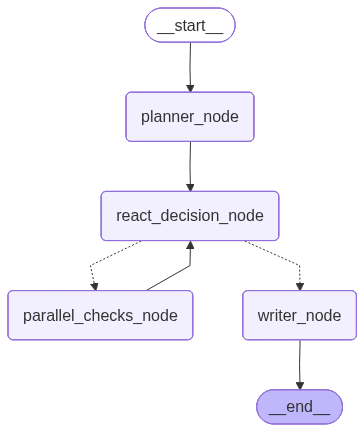

In [5]:
# Компиляция графа и визуализация
app = build_graph()

try:
    graph_png = app.get_graph().draw_mermaid_png()
    display(Image(data=graph_png))
except Exception:
    print(app.get_graph().draw_mermaid())

Параллелизм:

В узле `ParallelChecksNode` запускаются две независимые проверки:

- `run_ruff_check(target_path)`
- `run_radon_complexity(target_path)`

Они не зависят друг от друга, поэтому выполняются параллельно, а затем результаты объединяются в `state.tool_outputs`.

In [3]:
# Сквозной запуск (query -> plan -> tools -> final report)
result = run_audit(
    query="Проведи аудит этого проекта и выдели наиболее рискованные места",
    target_path="../test_project/",
    simulate_retry=False,
)

print("Следующее действие:", result.get("next_action"))
print("Количество результатов инструментов:", len(result.get("tool_outputs", [])))
print("Количество ReAct-решений:", len(result.get("react_history", [])))

/Users/dkravchenko/Downloads/lab1/.venv/lib/python3.12/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=ReactDecision(action='fin... кода.', done=True), input_type=ReactDecision])
  return self.__pydantic_serializer__.to_python(


Следующее действие: finish
Количество результатов инструментов: 2
Количество ReAct-решений: 2


/Users/dkravchenko/Downloads/lab1/.venv/lib/python3.12/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=AuditReport(summary='В ...емы решены.']), input_type=AuditReport])
  return self.__pydantic_serializer__.to_python(


In [ ]:
# Печать структурированных объектов (Pydantic)
plan_obj = result.get("plan")
report_obj = result.get("report")

print("=== AuditPlan ===")
if plan_obj is not None:
    pprint(plan_obj.model_dump())

print("\n=== AuditReport ===")
if report_obj is not None:
    pprint(report_obj.model_dump())

=== AuditPlan ===
{'checks': ['ruff', 'radon'],
 'priority': 'balanced',
 'scope': 'Аудит цели: ../test_project/'}

=== AuditReport ===
{'findings': [{'file': '/Users/dkravchenko/Downloads/lab1/test_project/Interaction.py',
               'message': 'F401: `Field` imported but unused',
               'severity': 'high',
               'suggestion': 'Исправьте lint-замечание и повторите аудит.'},
              {'file': '../test_project/Field.py',
               'message': 'Сложность D (27) в set_bombs',
               'severity': 'high',
               'suggestion': 'Рефакторинг длинных/ветвистых функций в более '
                             'мелкие блоки.'},
              {'file': '../test_project/Field.py',
               'message': 'Сложность B (6) в show_field',
               'severity': 'low',
               'suggestion': 'Рефакторинг длинных/ветвистых функций в более '
                             'мелкие блоки.'},
              {'file': '../test_project/Field.py',
             